In [3]:
# Nội dung phần báo cáo.
# 1 Mô tả tập dữ liệu và cho biết các thông tin của tập dữ liệu.
# 2 Tiền xử lý dữ liệu.
# 3 Thống kê mô tả và trực quan hóa dữ liệu.
# 4 Xây dựng mô hình Cây quyết định (Decision Tree), dùng GridSearch và Fold xác định tham số.
# 5 Đánh giá mô hình.
# 6 Xây dựng mô hình Losgistic Regression, KNN, Bayes và so sánh với mô hình Cây quyết định.

In [4]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, recall_score, r2_score, accuracy_score, roc_auc_score, precision_score, classification_report, log_loss

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Thư viện Grid Search CV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# Mô hình so sánh
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
# Dữ liệu đã được chia thành Age, Sex, Blood, Presure and Cholesterol của 200 bệnh nhân.
# Yêu cầu tìm loại thuốc Drug phù hợp cho bệnh nhân trong 5 loại thuốc.
df = pd.read_csv('drug200.csv', header=0, delimiter=',', encoding='utf-8')
df.head(4)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX


In [6]:
# fig, ax = plt.subplots(figsize=(10, 3)) 
# ax.axis('off')  
# ax.axis('tight') 
# table = ax.table(
#     cellText=df.head(10).values,
#     colLabels=df.columns,
#     loc='center',
#     cellLoc='center'
# )
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1.2, 1.2) 
# plt.savefig('dataframe_table.png', bbox_inches='tight', dpi=300)

Dự đoán thuốc thông qua chỉ số của bệnh nhân, sử dụng mô hình cây quyết định

In [7]:
# Kích thước tập dữ liệu
df.shape, df.columns

((200, 6),
 Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object'))

Khai phá -> Làm sạch -> Chuẩn hóa dữ liệu

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [9]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [10]:
# Các thang do lường của đặc trưng Cholesterol
df['Drug'].unique(), df['Cholesterol'].unique(), df['Sex'].unique(), df['BP'].unique()

(array(['drugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object),
 array(['HIGH', 'NORMAL'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['HIGH', 'LOW', 'NORMAL'], dtype=object))

In [11]:
# Số hóa nhãn
# BP = 'HIGH': 0, 'LOW': 1, 'NORMAL': 2
# Cholesterol = 'HIGH': 0, 'NORMAL': 1

In [12]:
# Kiểm tra dữ liệu bị thiếu
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

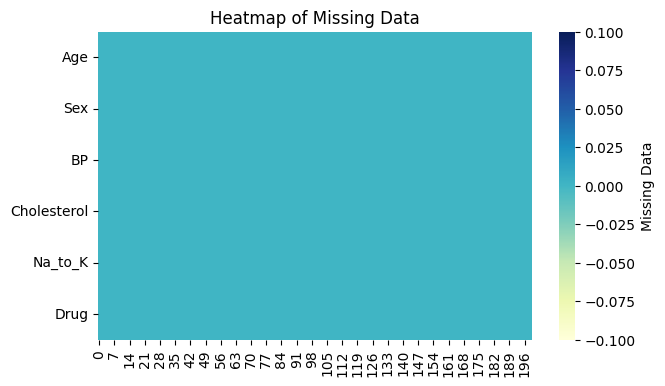

In [13]:
# Trực quan hóa dữ liệu thiếu
plt.figure(figsize=(7,4))
sns.heatmap(df.isna().transpose(), 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap of Missing Data')
# plt.savefig('missing_data_heatmap.png')
plt.show()

In [14]:
# Kiểm tra tính hợp lệ các dữ liệu số
def validate_numerical_data(df):
    # Check if 'Age' and 'Na_to_K' columns exist
    required_columns = ['Age', 'Na_to_K']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame.")
    # Check if the values in 'Age' and 'Na_to_K' are numerical and greater than 0
    for col in required_columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must be numerical.")
        if (df[col] <= 0).any():
            raise ValueError(f"Column '{col}' must contain values greater than 0.")
    return True

In [15]:
val = validate_numerical_data(df)
if(val):
    print("Dữ liệu số đã hợp lệ.")
else:
    print("Dữ liệu số không hợp lệ.")

Dữ liệu số đã hợp lệ.


In [16]:
# Kiểm tra giá trị trùng lặp
df.duplicated().sum()

np.int64(0)

Trực quan hóa qua biểu đồ pie, bar, box-plot, line

In [17]:
# Đổi tên cột và dữ liệu định tính trong cột
df.rename(columns={ 
    'Na_to_K': 'Sodium_to_Potassium', 
    'BP': 'Blood_Pressure'
}, inplace=True) 
df['Sex'] = df['Sex'].replace({'M': 'Male', 'F': 'Female'})
# Làm tròn giá trị trong cột Sodium_to_Potassium
df['Sodium_to_Potassium'] = df['Sodium_to_Potassium'].round(0).astype(int)
df.head(4)

,Age,Sex,Blood_Pressure,Cholesterol,Sodium_to_Potassium,Drug
0,23,Female,HIGH,HIGH,25,drugY
1,47,Male,LOW,HIGH,13,drugC
2,47,Male,LOW,HIGH,10,drugC
3,28,Female,NORMAL,HIGH,8,drugX


In [18]:
# Ma trận tương quan của Age, Sodium_to_Potassium
corr_age_na_to_k = df[['Age', 'Sodium_to_Potassium']].corr()
corr_age_na_to_k
# => Nhận xét: Không có tương quan giữa Age và Sodium_to_Potassium

,Age,Sodium_to_Potassium
Age,1.000000,-0.063748
Sodium_to_Potassium,-0.063748,1.000000


In [19]:
# Ma trận hiệp phương sai giữa Age và Sodium_to_Potassium
cov_age_na_to_k =np.cov(df['Age'], df['Sodium_to_Potassium'])
cov_age_na_to_k

array([[273.71434673,  -7.64396985],
       [ -7.64396985,  52.53015075]])

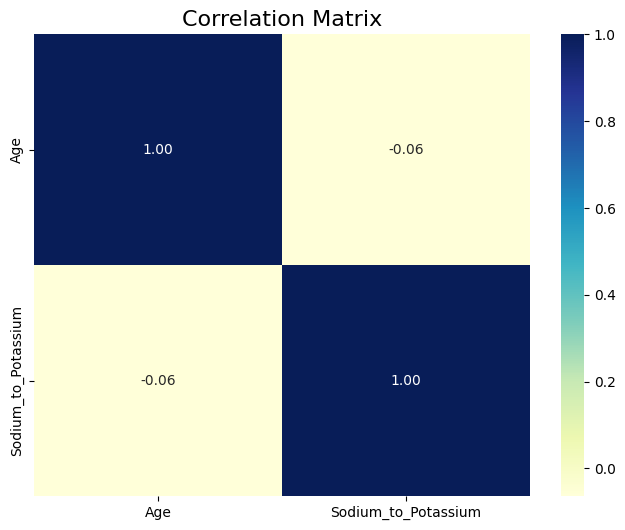

In [20]:
plt.figure(figsize=(8, 6))  # Đặt kích thước cho heatmap
sns.heatmap(corr_age_na_to_k, annot=True, fmt='.2f', cmap='YlGnBu')  
plt.title("Correlation Matrix", fontsize=16)
# plt.savefig("corr_matrix.png")
plt.show()


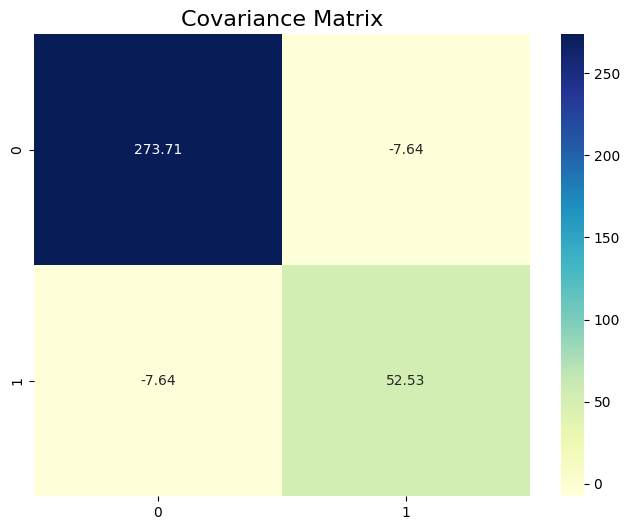

In [21]:
plt.figure(figsize=(8, 6))  # Đặt kích thước cho heatmap
sns.heatmap(cov_age_na_to_k, annot=True, fmt='.2f', cmap='YlGnBu')  
plt.title("Covariance Matrix", fontsize=16)
# plt.savefig("./result-images/cov_matrix.png")
# ma trận hiệp phương sai
plt.show()

In [22]:
# Đưa ra trung bình, trung vị, độ lệch chuẩn, khoảng phân vị của cột Age và Sodium_to_Potassium
df[['Age', 'Sodium_to_Potassium']].describe(include='all').round(2)

,Age,Sodium_to_Potassium
count,200.00,200.00
mean,44.32,16.05
std,16.54,7.25
min,15.00,6.00
25%,31.00,10.00
50%,45.00,14.00
75%,58.00,19.00
max,74.00,38.00


In [23]:
# Trực quan hóa pie chart về Cholesterol, Sex, Blood_Pressure và Drug
def plot_pie_chart(ax, column_name, df):
    gb = df.groupby([column_name])[column_name].agg(['count'])
    labels = gb.index 
    data = list(gb['count']) 
    colors = sns.color_palette('pastel') 
    ax.pie(data, labels=labels, colors=colors, 
           autopct='%1.1f%%', shadow=True)
    ax.set_title('Pie chart of ' + column_name)

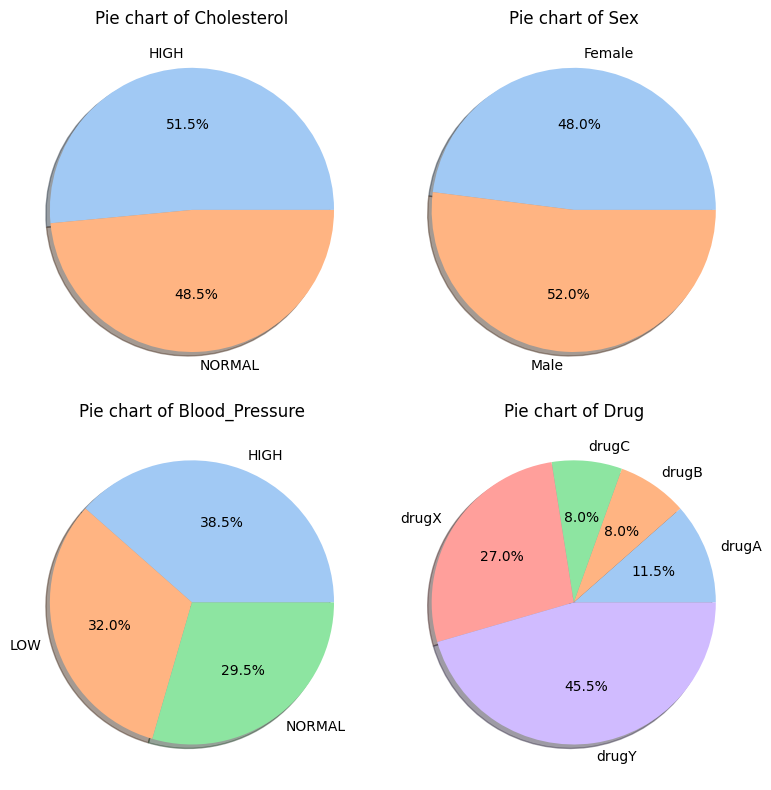

In [24]:
# plt.figure(figsize=(4,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plot_pie_chart(axs[0, 0], 'Cholesterol', df)
plot_pie_chart(axs[0, 1], 'Sex', df)
plot_pie_chart(axs[1, 0], 'Blood_Pressure', df)
plot_pie_chart(axs[1, 1], 'Drug', df)
plt.tight_layout()
plt.show()

In [25]:
# Create plot
def create_plot(ax, x, data, plot_type='count', y=None, palette='Set2'):
    if plot_type == 'count':
        sns.countplot(x=x, hue=x, data=data, palette=palette, ax=ax)
    elif plot_type == 'bar':
        sns.barplot(x=x, hue=x, y=y, data=data, palette=palette, ax=ax)
    ax.set_title(f'Plot of {x}' if plot_type == 'count' else f'Bar plot of {x} and {y}')
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='baseline',
            fontsize=10, color='black',
            xytext=(0, 1),
            textcoords='offset points')

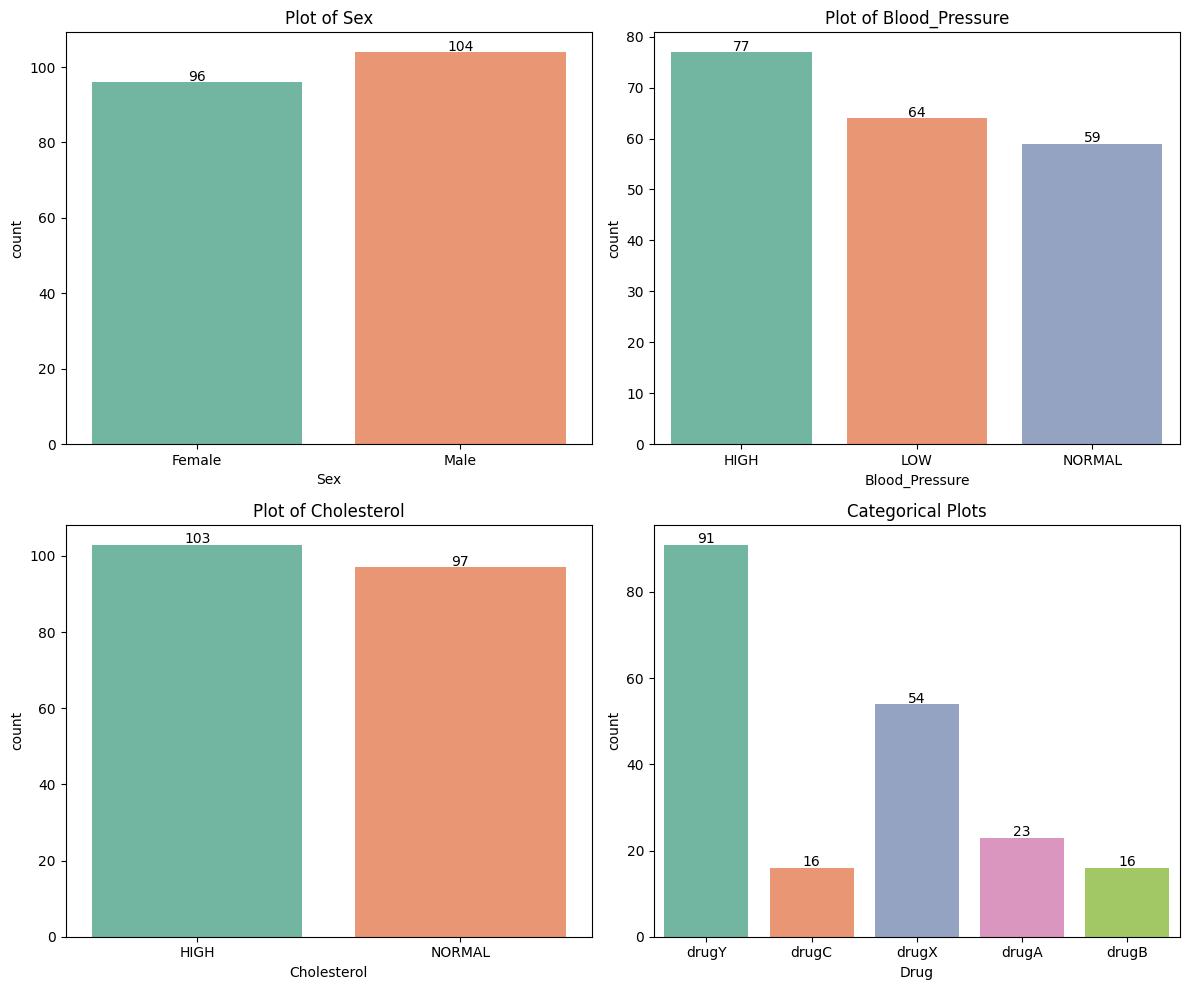

In [26]:
# Sử dụng 6 vị trí: 2 hàng x 3 cột
plt.figure(figsize=(12, 10)) 
age_counts = df['Age'].count()
plot_configs = [
    {'x': 'Sex', 'data': df, 'plot_type': 'count'},
    {'x': 'Blood_Pressure', 'data': df, 'plot_type': 'count'},
    {'x': 'Cholesterol', 'data': df, 'plot_type': 'count'},
    {'x': 'Drug', 'data': df, 'plot_type': 'count'},
]
for i, config in enumerate(plot_configs):
    # Dùng 2 hàng, 3 cột
    ax = plt.subplot(2, 2, i + 1)
    create_plot(ax, **config)
plt.tight_layout()
plt.title('Categorical Plots')
# plt.savefig('categorical_plots.png')
plt.show()

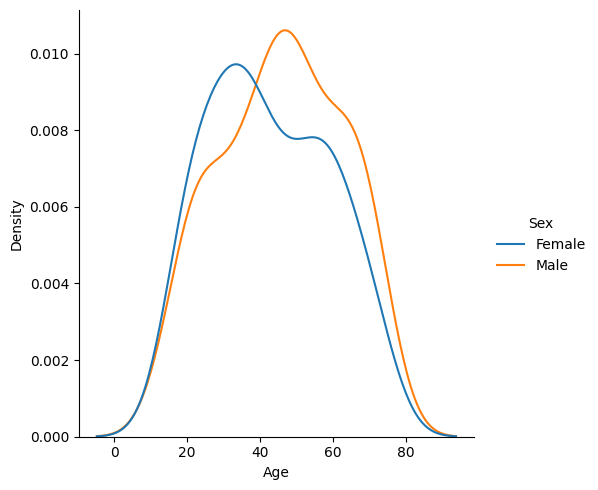

In [27]:
# Mô tả tuổi theo nhóm giới tính
sns.displot(df, x='Age', hue='Sex', kind='kde')
plt.show()

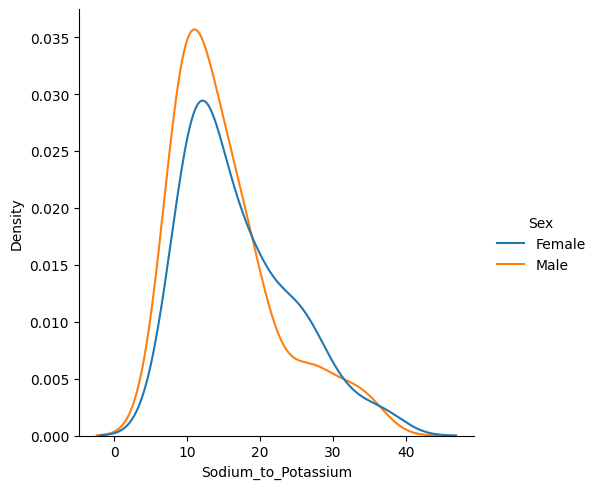

In [28]:
# Mô tả chỉ số Na to K theo giới tính
sns.displot(df, x='Sodium_to_Potassium', hue='Sex', kind='kde')
plt.show()

In [29]:
# Phân phối và mức độ nhọn cột Age, Sodium_to_Potassium
def check_skewness(col):
    skewness = df[col].skew()
    if skewness > 1:
        return "Lệch phải mạnh (Highly right-skewed)"
    elif 0.5 < skewness <= 1:
        return "Lệch phải vừa phải (Moderately right-skewed)"
    elif -0.5 <= skewness <= 0.5:
        return "Gần đối xứng (Approximately symmetric)"
    elif -1 <= skewness < -0.5:   
        return "Lệch trái vừa phải (Moderately left-skewed)"
    else:  
        return "Lệch trái mạnh (Highly left-skewed)"
def check_kurtosis(col):
    kurt_value = df[col].kurtosis()
    if kurt_value > 0.1:
        return "Leptokurtic: đỉnh nhọn hơn và đuôi nặng."
    elif kurt_value < -0.1:
        return "Platykurtic: đỉnh phẳng hơn và đuôi nhẹ."
    else:
        return "Mesokurtic: đỉnh đều tạo phân phối chuẩn."
# if kurt_value > 0.1: # Sử dụng ngưỡng lớn hơn 0 một chút để có tính thực tế hơn
#     phan_loai = "Leptokurtic"
#     mo_ta = "Đỉnh nhọn hơn và đuôi nặng hơn (Kurtosis > 0)."
# elif kurt_value < -0.1: # Sử dụng ngưỡng nhỏ hơn 0 một chút
#     phan_loai = "Platykurtic"
#     mo_ta = "Đỉnh phẳng hơn và đuôi nhẹ hơn (Kurtosis < 0)."
# else:
#     phan_loai = "Mesokurtic"

In [30]:
print('Skewness Age:',check_skewness('Age'))
print('Skewness Sodium_to_Potassium:',check_skewness('Sodium_to_Potassium'))

Skewness Age: Gần đối xứng (Approximately symmetric)
Skewness Sodium_to_Potassium: Lệch phải mạnh (Highly right-skewed)


In [31]:
print('Kurtosis Age:',check_kurtosis('Age'))
print('Kurtosis Sodium_to_Potassium:',check_kurtosis('Sodium_to_Potassium'))

Kurtosis Age: Platykurtic: đỉnh phẳng hơn và đuôi nhẹ.
Kurtosis Sodium_to_Potassium: Leptokurtic: đỉnh nhọn hơn và đuôi nặng.


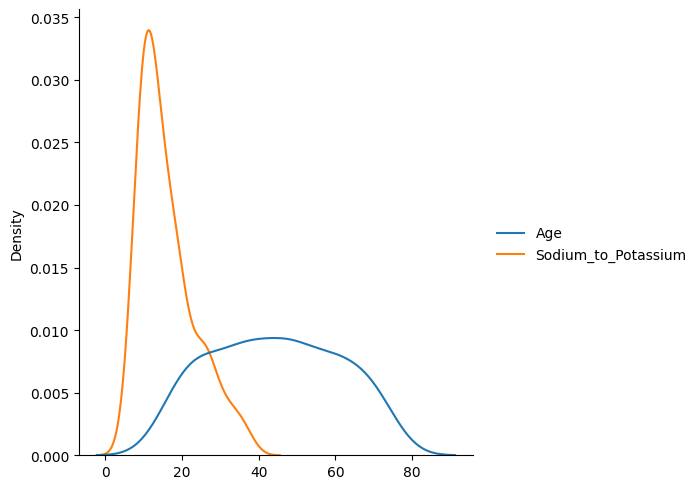

In [32]:
sns.displot(data = df[['Age', 'Sodium_to_Potassium']], kind='kde')
# plt.savefig('kde_age_na_to_k.png')
plt.show()

Tính toán các đặc trưng cơ bản

In [33]:
# Tính chỉ số Gini cho cột Drug
def gini_index(list_values):
    arr = np.array(list_values)
    return 1 - np.sum((arr/np.sum(arr))**2)
gini_drug = gini_index(df['Drug'].value_counts())
print('Gini index of Drug:', gini_drug)
# Gini = 0.69405 => Nhận xét: Chỉ số Gini cho thấy sự đa dạng trong việc phân loại thuốc.

Gini index of Drug: 0.69405


In [34]:
# Tính toán Entropy
def calculate_entropy(data, label_column):
    total_count = len(data)
    class_counts = data[label_column].value_counts()
    probabilities = class_counts / total_count
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy
# Gọi hàm để tính entropy
entropy_value = calculate_entropy(df, 'Drug')
print(f'Entropy of the dataset is: {entropy_value}')
# Entropy khoảng 1.9688 cho thấy tập dữ liệu có ít nhất 4 lớp (vì log₂(4) = 2).

Entropy of the dataset is: 1.968780377953625


# Xây dựng mô hình phân loại cây quyết định

In [35]:
# Chọn đặc trưng tập đầu vào và tập đầu ra
X = df.iloc[:,:-1] 
y = df.iloc[:, -1]

In [36]:
X

,Age,Sex,Blood_Pressure,Cholesterol,Sodium_to_Potassium
0,23,Female,HIGH,HIGH,25
1,47,Male,LOW,HIGH,13
2,47,Male,LOW,HIGH,10
3,28,Female,NORMAL,HIGH,8
4,61,Female,LOW,HIGH,18
...,...,...,...,...,...
195,56,Female,LOW,HIGH,12
196,16,Male,LOW,HIGH,12
197,52,Male,NORMAL,HIGH,10
198,23,Male,NORMAL,NORMAL,14


In [37]:
y

0      drugY
1      drugC
2      drugC
3      drugX
4      drugY
       ...  
195    drugC
196    drugC
197    drugX
198    drugX
199    drugX
Name: Drug, Length: 200, dtype: object

In [38]:
# One Hot Encoder cho cột 'Sex'
one_hot_encoder_sex = OneHotEncoder(sparse_output=False) 
# drop='first' để tránh multicollinearity (tùy chọn)
one_hot_encoded = one_hot_encoder_sex.fit_transform(X[['Sex']])  
# Dùng fit_transform
one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder_sex.get_feature_names_out(['Sex']), index=X.index)
X = pd.concat([X, one_hot_df], axis=1)
X = X.drop('Sex', axis=1)  # Drop cột gốc

# Label Encoder cho Blood_Pressure và Cholesterol
labelled_encoder_blood_pressure = LabelEncoder()
labelled_encoder_cholesterol = LabelEncoder()

X['Blood_Pressure'] = labelled_encoder_blood_pressure.fit_transform(X['Blood_Pressure'])
X['Cholesterol'] = labelled_encoder_cholesterol.fit_transform(X['Cholesterol'])

X['Sex_Female'] = X['Sex_Female'].round(0).astype(int)
X['Sex_Male'] = X['Sex_Male'].round(0).astype(int)
# Show features
# data
X

,Age,Blood_Pressure,Cholesterol,Sodium_to_Potassium,Sex_Female,Sex_Male
0,23,0,0,25,1,0
1,47,1,0,13,0,1
2,47,1,0,10,0,1
3,28,2,0,8,1,0
4,61,1,0,18,1,0
...,...,...,...,...,...,...
195,56,1,0,12,1,0
196,16,1,0,12,0,1
197,52,2,0,10,0,1
198,23,2,1,14,0,1


In [39]:
# Có thể thay đổi tham số
test_train_size = 0.4
random_state_to_split = 42

In [40]:
# Tách 2 tập với tỉ lệ là 6/4 random state là 42
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_train_size, random_state=random_state_to_split)

In [41]:
# Sử dụng Grid Search CV và K-Fold để tìm tham số tốt nhất cho mô hình Decision Tree
dtc = DecisionTreeClassifier(criterion='entropy')
# Determine fold as 5 and scoring accuracy
score_cross_val = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy').mean()
print('Performance of Decision Tree using Cross Validation:', score_cross_val)

Performance of Decision Tree using Cross Validation: 0.9833333333333334


In [42]:
# Đưa ra các tham số cây quyết định tốt nhất
dtc = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 5, 10], 
    'criterion': ['gini', 'entropy'], 
    'max_leaf_nodes': range (5,10)
}
# 5-fold cross-validation, chọn fold là 5
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'max_leaf_nodes': range(5, 10), 'min_samples_split': [2, 5, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and para

In [43]:
# Tham số tốt nhất và độ chính xác tương ứng
print('Best Hyperparameters:', grid_search.best_params_)
print('Best Accuracy:', grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 6, 'min_samples_split': 2}
Best Accuracy: 0.9833333333333334


In [44]:
max_dept_best_params = grid_search.best_params_['max_depth']
criterion_best_params = grid_search.best_params_['criterion']
max_leaf_nodes_best_params = grid_search.best_params_['max_leaf_nodes']
min_samples_leaf_best_params = grid_search.best_params_['min_samples_split']

In [45]:
# max_dept: độ sâu tối đa
# criterion: hàm đo độ tinh khiết để chọn nhánh
# max_leaf_nodes: số lượng lá tối đa trong cây
# min_samples_leaf: Số mẫu tối thiểu ở lá

In [46]:
# Tạo cây quyết định có chiều sâu đối đa là 6, node trái tối đa là 10
# dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=10)

dtc = DecisionTreeClassifier(max_depth=max_dept_best_params, criterion=criterion_best_params, 
                             max_leaf_nodes=max_leaf_nodes_best_params, 
                             min_samples_leaf=min_samples_leaf_best_params)
dtc.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",6
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current nod

In [47]:
score_train = dtc.score(X_train, y_train)
score_train_dtc = score_train
score_test = dtc.score(X_test, y_test)
print(f'Accuracy on Training set: {score_train:4f}')
print(f'Accuracy on Testing set: {score_test:4f}')

Accuracy on Training set: 0.991667
Accuracy on Testing set: 1.000000


In [48]:
# Phân loại lớp
dtc.classes_

array(['drugA', 'drugB', 'drugC', 'drugX', 'drugY'], dtype=object)

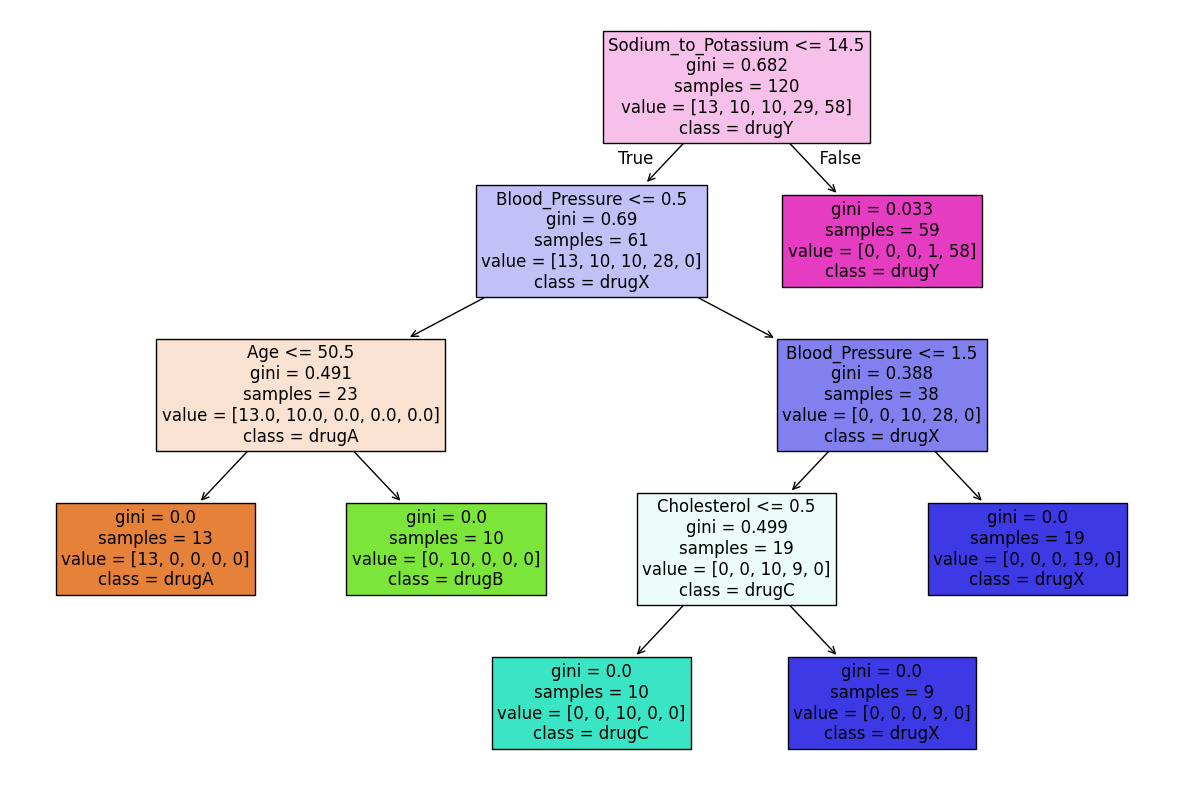

In [49]:
# Trực quan cây quyết định
feature_cols = X_train.columns
plt.figure(figsize=(15,10))
plot_tree(dtc, class_names=dtc.classes_, feature_names=feature_cols, fontsize=12, filled=True)
# plt.savefig('decision_tree.png')
plt.show()

In [50]:
# Predict y test predict
# Dự đoán tập y test
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)
y_test_pred_proba = dtc.predict_proba(X_test)

# Đánh giá mô hình

In [51]:
# Accuracy score, how ofter is the classifier correct ?
acc_score = accuracy_score(y_test, y_test_pred)
loss_score = log_loss(y_test, y_test_pred_proba)
accuracy_score_dtc = acc_score
loss_score_dtc = loss_score

print("Accuracy score:", 100*acc_score)
print("Loss score:", round(100 * loss_score, 2))

Accuracy score: 100.0
Loss score: 0.71


In [52]:
# Ma trận nhầm lẫn (Confusion Matrix)
cf_matrix = confusion_matrix(y_test, y_test_pred)
cf_matrix

array([[10,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 0,  0,  6,  0,  0],
       [ 0,  0,  0, 25,  0],
       [ 0,  0,  0,  0, 33]])

In [53]:
def plot_confusion_matrix(cf_matrix):
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=dtc.classes_, yticklabels=dtc.classes_)
    plt.ylabel("Prediction", fontsize=12)
    plt.xlabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

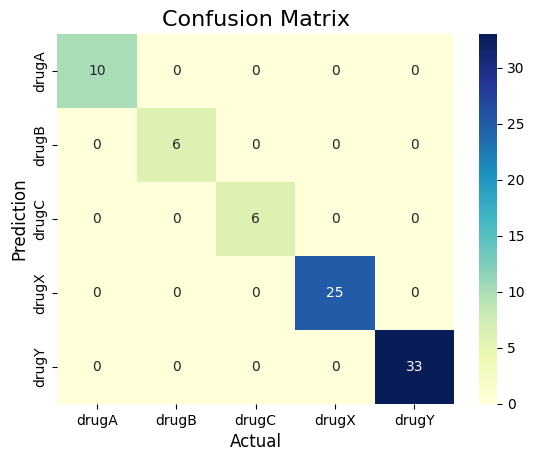

In [54]:
# Plot the confusion matrix
plot_confusion_matrix(cf_matrix)

In [55]:
precision = precision_score(y_test, y_test_pred, average=None)
micro_precision = precision_score(y_test, y_test_pred, average='micro')
macro_precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)
report_classification = classification_report(y_test, y_test_pred)

In [56]:
print('Precision score:', precision)
print('Micro precision score:', micro_precision)
print('Macro precision score:', macro_precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Confusion Matrix:\n',cf_matrix)
print('Classification report:\n', report_classification)

Precision score: [1. 1. 1. 1. 1.]
Micro precision score: 1.0
Macro precision score: 1.0
Recall score: [1. 1. 1. 1. 1.]
F1 score: [1. 1. 1. 1. 1.]
Confusion Matrix:
 [[10  0  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0 33]]
Classification report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00        10
       drugB       1.00      1.00      1.00         6
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        25
       drugY       1.00      1.00      1.00        33

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [57]:
# Prediction
age = 32
blood = 'HIGH'
blood_scaled = labelled_encoder_blood_pressure.transform([blood])

cholesterol = 'NORMAL'
cholesterol_scaled = labelled_encoder_blood_pressure.transform([cholesterol])

Sodium_to_Potassium = 13
# Số hóa ngược
sex = 'Female'
sex_female = 1 if sex == 'Female' else 0
sex_male   = 1 if sex == 'Male'   else 0

In [58]:
feature_sample = pd.DataFrame([[age, blood_scaled[0], 
                                cholesterol_scaled[0], 
                                Sodium_to_Potassium, 
                                sex_female, 
                                sex_male]], 
                              columns=X.columns)
feature_sample

,Age,Blood_Pressure,Cholesterol,Sodium_to_Potassium,Sex_Female,Sex_Male
0,32,0,2,13,1,0


In [59]:
y_sample_pred = dtc.predict(feature_sample)
y_sample_pred

array(['drugA'], dtype=object)

In [60]:
X_train.columns

Index(['Age', 'Blood_Pressure', 'Cholesterol', 'Sodium_to_Potassium',
       'Sex_Female', 'Sex_Male'],
      dtype='object')

In [61]:
y_test

95     drugX
15     drugY
30     drugX
158    drugC
128    drugY
       ...  
113    drugX
26     drugY
139    drugX
100    drugA
111    drugX
Name: Drug, Length: 80, dtype: object

In [62]:
dfPredict_DTC = pd.DataFrame({
    'y_test': y_test,
    'y_test_predicted': y_test_pred,
})
dfPredict_DTC['Correct_Prediction'] = (y_test == y_test_pred).astype(int)
dfPredict_DTC

,y_test,y_test_predicted,Correct_Prediction
95,drugX,drugX,1
15,drugY,drugY,1
30,drugX,drugX,1
158,drugC,drugC,1
128,drugY,drugY,1
...,...,...,...
113,drugX,drugX,1
26,drugY,drugY,1
139,drugX,drugX,1
100,drugA,drugA,1


# So sánh với các mô hình Logistic Regression, K-Nearest Neighbors (KNN), Naive Bayes

Logistic

In [63]:
steps_to_fit_logistic=[('standardscaler',StandardScaler()),('logreg',LogisticRegression())]
pipe_logistic = Pipeline(steps_to_fit_logistic)
pipe_logistic.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, m

Coefficients: [[-0.84376904 -1.85581335 -0.4185166  -1.29977236 -0.00415638  0.00415638]
 [ 1.41471881 -1.60660909  0.21027513 -0.25792898 -0.04928863  0.04928863]
 [-0.33190374  0.31971781 -1.15048455 -0.8728242  -0.10894065  0.10894065]
 [-0.20489318  2.49246221  1.141595   -1.17861976  0.11633963 -0.11633963]
 [-0.03415286  0.65024243  0.21713103  3.6091453   0.04604603 -0.04604603]]
Intercept: [-1.32885034 -1.39675296 -0.41659763  0.26201315  2.88018779]
Classes: ['drugA' 'drugB' 'drugC' 'drugX' 'drugY']
Accuracy on Training set: 0.975000
Accuracy on Testing set: 0.912500
Accuracy score: 91.25
Loss score: 31.1
Confusion Matrix for Logistic Regression:
[[10  0  0  0  0]
 [ 1  5  0  0  0]
 [ 0  0  4  0  2]
 [ 0  0  0 25  0]
 [ 0  2  0  2 29]]


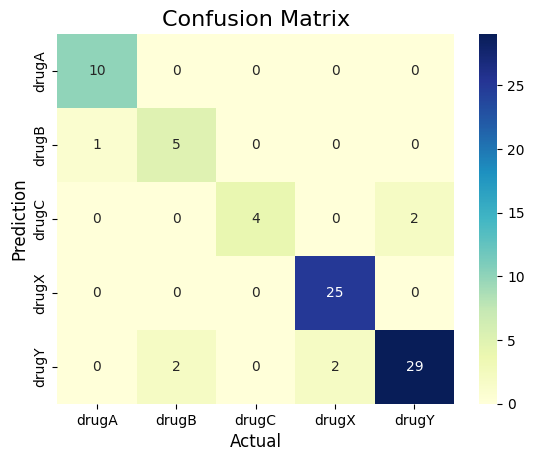

Precision score: [0.90909091 0.71428571 1.         0.92592593 0.93548387]
Micro precision score: 0.9125
Macro precision score: 0.8969572840540583
Recall score: [1.         0.83333333 0.66666667 1.         0.87878788]
F1 score: [0.95238095 0.76923077 0.8        0.96153846 0.90625   ]
Classification report:
               precision    recall  f1-score   support

       drugA       0.91      1.00      0.95        10
       drugB       0.71      0.83      0.77         6
       drugC       1.00      0.67      0.80         6
       drugX       0.93      1.00      0.96        25
       drugY       0.94      0.88      0.91        33

    accuracy                           0.91        80
   macro avg       0.90      0.88      0.88        80
weighted avg       0.92      0.91      0.91        80



In [64]:
coefficients = pipe_logistic.named_steps['logreg'].coef_
intercept = pipe_logistic.named_steps['logreg'].intercept_
number_of_classes = pipe_logistic.named_steps['logreg'].classes_
print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("Classes:", number_of_classes)

score_train = pipe_logistic.score(X_train, y_train)
score_train_logistic = score_train
score_test = pipe_logistic.score(X_test, y_test)
print(f'Accuracy on Training set: {score_train:4f}')
print(f'Accuracy on Testing set: {score_test:4f}')

y_train_pred = pipe_logistic.predict(X_train)
y_test_pred = pipe_logistic.predict(X_test)
y_test_pred_proba = pipe_logistic.predict_proba(X_test)

acc_score = accuracy_score(y_test, y_test_pred)
loss_score = log_loss(y_test, y_test_pred_proba)
accuracy_score_logistic = acc_score
loss_score_logistic = loss_score
print("Accuracy score:", 100*acc_score)
print("Loss score:", round(100 * loss_score, 2))

# Ma trận nhầm lẫn (Confusion Matrix)
cf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Logistic Regression:")
print(cf_matrix)
plot_confusion_matrix(cf_matrix)

precision = precision_score(y_test, y_test_pred, average=None)
micro_precision = precision_score(y_test, y_test_pred, average='micro')
macro_precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)
report_classification = classification_report(y_test, y_test_pred)

print('Precision score:', precision)
print('Micro precision score:', micro_precision)
print('Macro precision score:', macro_precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Classification report:\n', report_classification)

In [65]:
dfPredict_Logistic = pd.DataFrame({
    'y_test': y_test,
    'y_test_predicted': y_test_pred,
})
dfPredict_Logistic['Correct_Prediction'] = (y_test == y_test_pred).astype(int)
dfPredict_Logistic

,y_test,y_test_predicted,Correct_Prediction
95,drugX,drugX,1
15,drugY,drugY,1
30,drugX,drugX,1
158,drugC,drugC,1
128,drugY,drugY,1
...,...,...,...
113,drugX,drugX,1
26,drugY,drugY,1
139,drugX,drugX,1
100,drugA,drugA,1


KNN

In [66]:
# KNN Model
# Xác định số cụm đạt độ chính xác cao nhất
# Danh sách số lượng neighbors cần thử: từ 1 đến 50
range_first = 1
range_last = 50
neighbors = list(range(range_first, range_last))
accuracies = []
for k in neighbors:
    # Tạo và huấn luyện mô hình KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Dự đoán và tính độ chính xác
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
df_knn_results = pd.DataFrame({
    'n_neighbors': neighbors,
    'Accuracy': accuracies,
    'Accuracy (%)': [acc * 100 for acc in accuracies]
})
df_knn_results['Accuracy (%)'] = df_knn_results['Accuracy (%)'].round(4)
df_knn_results = df_knn_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
n_neighbors_best = df_knn_results.loc[0, 'n_neighbors']

a_index = list(range(range_first, range_last))
l_index = list(range(range_first, range_last))
a = pd.Series(dtype=float) 
l = pd.Series(dtype=float) 

df_knn_results.head(10)

,n_neighbors,Accuracy,Accuracy (%)
0,8,0.7625,76.25
1,9,0.7250,72.50
2,4,0.7125,71.25
3,6,0.7125,71.25
4,7,0.7000,70.00
5,10,0.7000,70.00
6,1,0.6875,68.75
7,11,0.6875,68.75
8,3,0.6625,66.25
9,16,0.6625,66.25


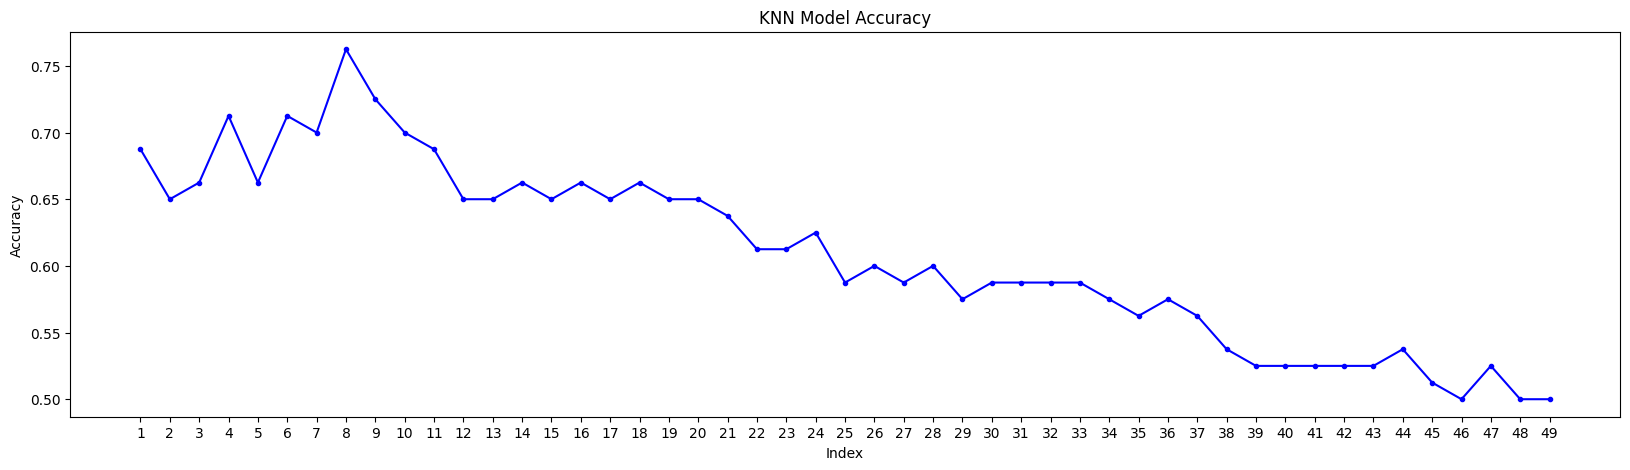

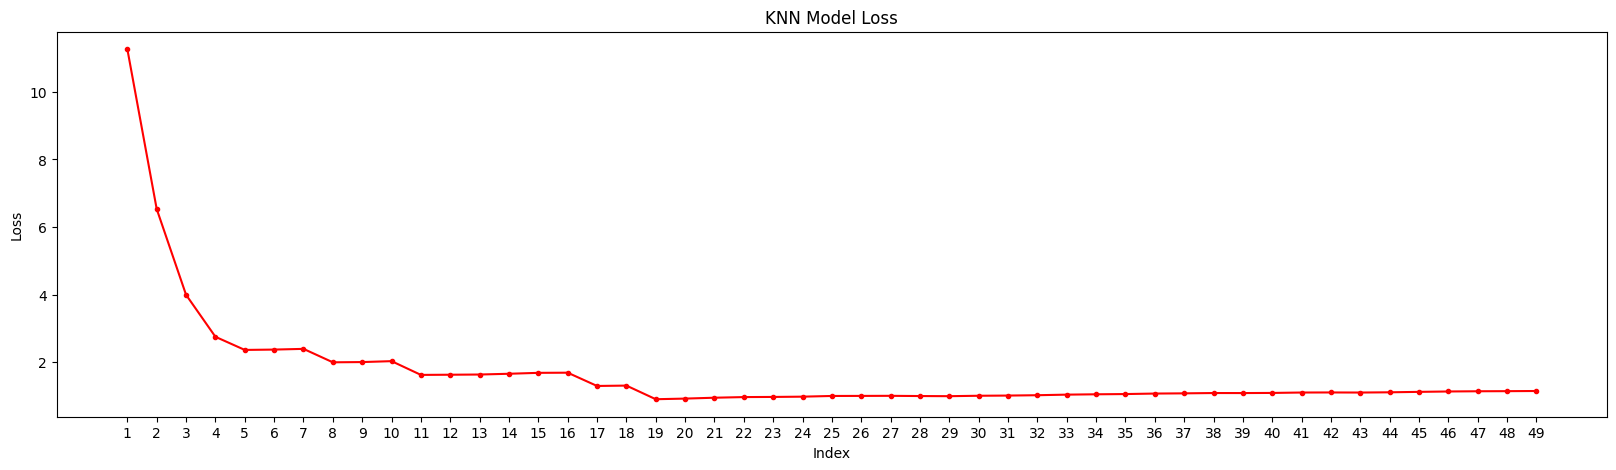

In [67]:
# View plot result KNN Accuracy, Loss
plt.subplots(figsize=(20, 5))
for i in a_index:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    # y_prediction_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_prediction)
    # loss = log_loss(y_test, y_prediction_proba)
    if accuracy is not None:
        a = pd.concat([a, pd.Series([accuracy])], ignore_index=True)
    # if loss is not None:
    #     l = pd.concat([l, pd.Series([loss])], ignore_index=True)
plt.plot(a_index, a, marker=".", color='blue', label = 'Accuracy')
# plt.plot(l_index, l, marker=".", color='red', label = 'Loss')
plt.xticks(a_index)
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy')
plt.show()

plt.subplots(figsize=(20, 5))
for i in a_index:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    y_prediction_proba = model.predict_proba(X_test)
    loss = log_loss(y_test, y_prediction_proba)
    if loss is not None:
        l = pd.concat([l, pd.Series([loss])], ignore_index=True)
plt.plot(l_index, l, marker=".", color='red', label = 'Loss')
plt.xticks(a_index)
plt.xlabel('Index')
plt.ylabel('Loss')
plt.title('KNN Model Loss')
plt.show()

In [68]:
# Huấn luyện mô hình với k = 9
knnModel = KNeighborsClassifier(n_neighbors=n_neighbors_best)
knnModel.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",np.int64(8)
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


Accuracy on Training set: 0.733333
Accuracy on Testing set: 0.762500
Accuracy score: 76.25
Loss score: 199.68979837184958
Confusion Matrix for KNN:
[[ 5  0  0  5  0]
 [ 0  4  0  2  0]
 [ 0  1  1  4  0]
 [ 0  5  1 19  0]
 [ 0  0  0  1 32]]


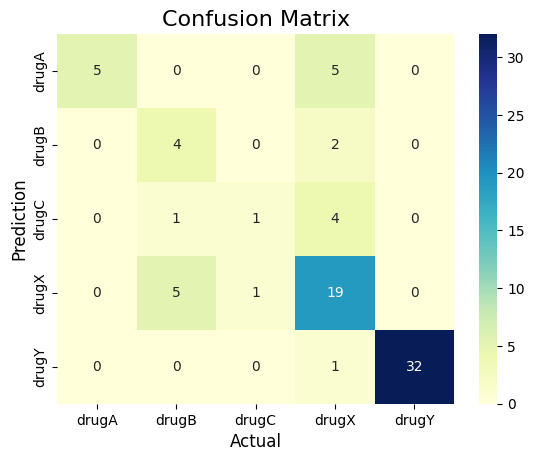

Precision score: [1.         0.4        0.5        0.61290323 1.        ]
Micro precision score: 0.7625
Macro precision score: 0.7025806451612903
Recall score: [0.5        0.66666667 0.16666667 0.76       0.96969697]
F1 score: [0.66666667 0.5        0.25       0.67857143 0.98461538]
Classification report:
               precision    recall  f1-score   support

       drugA       1.00      0.50      0.67        10
       drugB       0.40      0.67      0.50         6
       drugC       0.50      0.17      0.25         6
       drugX       0.61      0.76      0.68        25
       drugY       1.00      0.97      0.98        33

    accuracy                           0.76        80
   macro avg       0.70      0.61      0.62        80
weighted avg       0.80      0.76      0.76        80



In [69]:
score_train = knnModel.score(X_train, y_train)
score_train_knn = score_train
score_test = knnModel.score(X_test, y_test)
print(f'Accuracy on Training set: {score_train:4f}')
print(f'Accuracy on Testing set: {score_test:4f}')

y_train_pred = knnModel.predict(X_train)
y_test_pred = knnModel.predict(X_test)
y_test_pred_proba = knnModel.predict_proba(X_test)

acc_score = accuracy_score(y_test, y_test_pred)
loss_score = log_loss(y_test, y_test_pred_proba)
accuracy_score_knn = acc_score
loss_score_knn = loss_score
print("Accuracy score:", 100*acc_score)
print("Loss score:", 100*loss_score)

# Ma trận nhầm lẫn (Confusion Matrix)
cf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for KNN:")
print(cf_matrix)
plot_confusion_matrix(cf_matrix)

precision = precision_score(y_test, y_test_pred, average=None)
micro_precision = precision_score(y_test, y_test_pred, average='micro')
macro_precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)
report_classification = classification_report(y_test, y_test_pred)

print('Precision score:', precision)
print('Micro precision score:', micro_precision)
print('Macro precision score:', macro_precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Classification report:\n', report_classification)

In [70]:
dfPredict_KNN = pd.DataFrame({
    'y_test': y_test,
    'y_test_predicted': y_test_pred,
})
dfPredict_KNN['Correct_Prediction'] = (y_test == y_test_pred).astype(int)
dfPredict_KNN

,y_test,y_test_predicted,Correct_Prediction
95,drugX,drugX,1
15,drugY,drugY,1
30,drugX,drugX,1
158,drugC,drugB,0
128,drugY,drugY,1
...,...,...,...
113,drugX,drugB,0
26,drugY,drugY,1
139,drugX,drugB,0
100,drugA,drugA,1


Naive Bayes

In [71]:
# Naive Bayes Model
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


Accuracy on Training set: 0.858333
Accuracy on Testing set: 0.887500
Accuracy score: 88.75
Loss score: 71.21635979716532
Confusion Matrix for Naive Bayes:
[[10  0  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0 24  1]
 [ 1  3  3  1 25]]


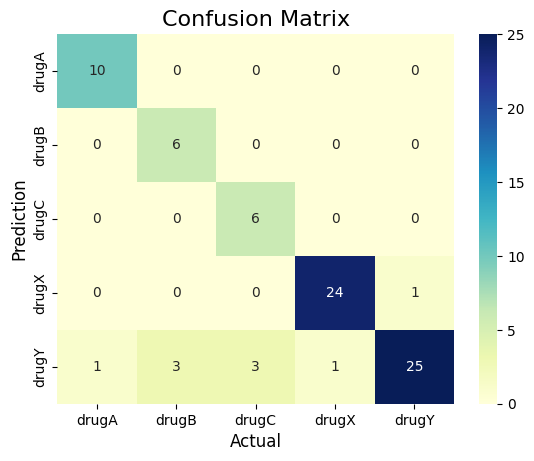

Precision score: [0.90909091 0.66666667 0.66666667 0.96       0.96153846]
Micro precision score: 0.8875
Macro precision score: 0.8327925407925407
Recall score: [1.         1.         1.         0.96       0.75757576]
F1 score: [0.95238095 0.8        0.8        0.96       0.84745763]
Classification report:
               precision    recall  f1-score   support

       drugA       0.91      1.00      0.95        10
       drugB       0.67      1.00      0.80         6
       drugC       0.67      1.00      0.80         6
       drugX       0.96      0.96      0.96        25
       drugY       0.96      0.76      0.85        33

    accuracy                           0.89        80
   macro avg       0.83      0.94      0.87        80
weighted avg       0.91      0.89      0.89        80



In [72]:
score_train = gaussian.score(X_train, y_train)
score_train_nb = score_train
score_test = gaussian.score(X_test, y_test)
print(f'Accuracy on Training set: {score_train:4f}')
print(f'Accuracy on Testing set: {score_test:4f}')

y_train_pred = gaussian.predict(X_train)
y_test_pred = gaussian.predict(X_test)
y_test_pred_proba = gaussian.predict_proba(X_test)

acc_score = accuracy_score(y_test, y_test_pred)
loss_score = log_loss(y_test, y_test_pred_proba)
accuracy_score_nb = acc_score
loss_score_nb = loss_score
print("Accuracy score:", 100*acc_score)
print("Loss score:", 100*loss_score)

# Ma trận nhầm lẫn (Confusion Matrix)
cf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Naive Bayes:")
print(cf_matrix)
plot_confusion_matrix(cf_matrix)

precision = precision_score(y_test, y_test_pred, average=None)
micro_precision = precision_score(y_test, y_test_pred, average='micro')
macro_precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)
report_classification = classification_report(y_test, y_test_pred)

print('Precision score:', precision)
print('Micro precision score:', micro_precision)
print('Macro precision score:', macro_precision)
print('Recall score:', recall)
print('F1 score:', f1)
print('Classification report:\n', report_classification)

In [73]:
dfPredict_Bayes = pd.DataFrame({
    'y_test': y_test,
    'y_test_predicted': y_test_pred,
})
dfPredict_Bayes['Correct_Prediction'] = (y_test == y_test_pred).astype(int)
dfPredict_Bayes

,y_test,y_test_predicted,Correct_Prediction
95,drugX,drugX,1
15,drugY,drugA,0
30,drugX,drugX,1
158,drugC,drugC,1
128,drugY,drugY,1
...,...,...,...
113,drugX,drugY,0
26,drugY,drugY,1
139,drugX,drugX,1
100,drugA,drugA,1


# So sánh các mô hình trên

In [74]:
# So sánh mô hình cây quyết định tham số tốt, Logistic, KNN, Naive Bayes
result_report = {
    'Model': ['Decision Tree', 'Logistic Regression', 'KNN', 'Naive Bayes'],
    'Score': [score_train_dtc, score_train_logistic, score_train_knn, score_train_nb],
    'Accuracy score': [accuracy_score_dtc, accuracy_score_logistic, accuracy_score_knn, accuracy_score_nb],
    'Loss score': [loss_score_dtc, loss_score_logistic, loss_score_knn, loss_score_nb]
}
results = pd.DataFrame(result_report)
results_df = results.sort_values(by='Accuracy score', ascending=False)
results_df = results_df.reset_index(drop=True)
# results_df['Accuracy score percent'] = round(results_df['Accuracy score'] * 100, 2)
results_df

,Model,Score,Accuracy score,Loss score
0,Decision Tree,0.991667,1.0000,0.007051
1,Logistic Regression,0.975000,0.9125,0.311039
2,Naive Bayes,0.858333,0.8875,0.712164
3,KNN,0.733333,0.7625,1.996898


In [75]:
# results_df_rounded = results_df.copy() 
# results_df_rounded[['Score', 'Accuracy score', 'Loss score']] = results_df[['Score', 'Accuracy score', 'Loss score']].round(2)
# fig, ax = plt.subplots(figsize=(10, 3)) 
# ax.axis('off')  
# ax.axis('tight') 
# table = ax.table(
#     cellText=results_df_rounded.values,
#     colLabels=results_df_rounded.columns,
#     loc='center',
#     cellLoc='center'
# )
# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1.2, 1.2) 
# plt.savefig('comparison_table_models.png', bbox_inches='tight', dpi=300)

In [76]:
# Hàm hiển thị bar chart so sánh các mô hình
# def plot_bar_comparison(column, results_df):
#     plt.subplots(figsize=(7, 2))
#     ax = sns.barplot(x='Model', y=column, data=results_df)
#     labels = results_df[column] 
#     for i, v in enumerate(labels):
#         ax.text(i, v + 0.01, str(round(v*100,2)), horizontalalignment='center', size=12, color='black')
#     plt.title(column)
#     plt.show()

In [77]:
# plot_bar_comparison('Accuracy score', results_df)
# plot_bar_comparison('Loss score', results_df)

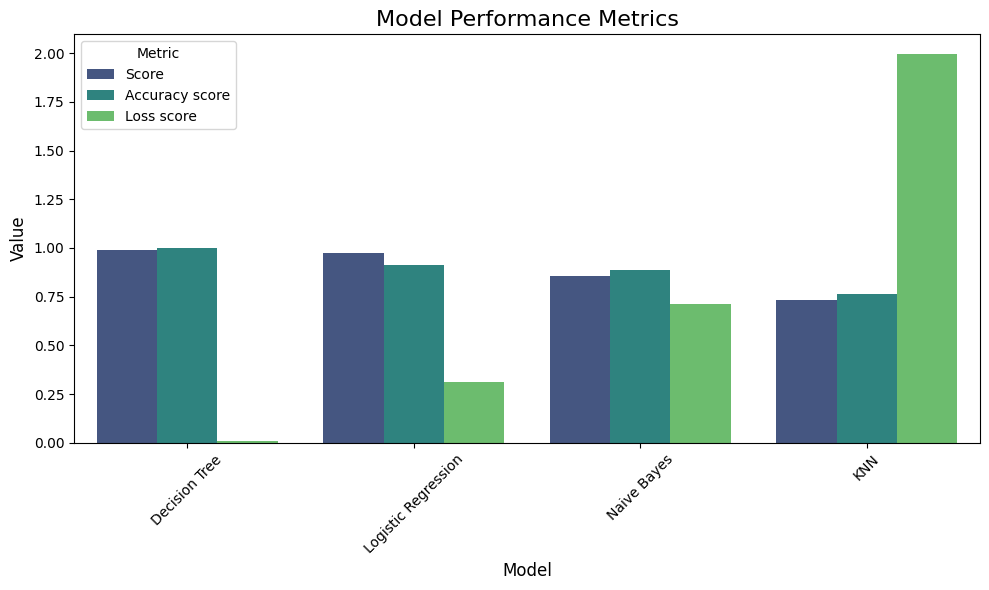

In [78]:
df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Value', hue='Metric', palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Metric')
plt.xticks(rotation=45)  
plt.tight_layout()  
# plt.savefig('barplot_model_comparison.png')
plt.show()

In [79]:
# So sánh các dự đoán chi tiết của các mô hình
print(f'Correct prediction rate Decision Tree: {dfPredict_DTC['Correct_Prediction'].sum()}/{len(dfPredict_DTC)}')
print(f'Correct prediction rate Logistic: {dfPredict_Logistic['Correct_Prediction'].sum()}/{len(dfPredict_Logistic)}')
print(f'Correct prediction rate KNN: {dfPredict_KNN['Correct_Prediction'].sum()}/{len(dfPredict_KNN)}')
print(f'Correct prediction rate Naive Bayes: {dfPredict_Bayes['Correct_Prediction'].sum()}/{len(dfPredict_Bayes)}')

Correct prediction rate Decision Tree: 80/80
Correct prediction rate Logistic: 73/80
Correct prediction rate KNN: 61/80
Correct prediction rate Naive Bayes: 71/80


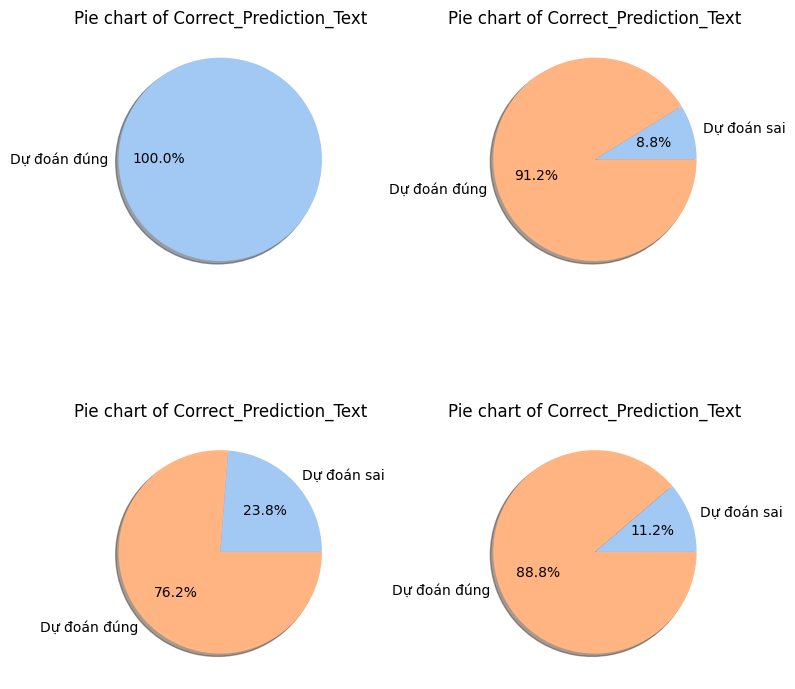

In [80]:
dfPredict_DTC['Correct_Prediction_Text'] = dfPredict_DTC['Correct_Prediction'].map({
    1: 'Dự đoán đúng',
    0: 'Dự đoán sai'
})

dfPredict_Logistic['Correct_Prediction_Text'] = dfPredict_Logistic['Correct_Prediction'].map({
    1: 'Dự đoán đúng',
    0: 'Dự đoán sai'
})

dfPredict_KNN['Correct_Prediction_Text'] = dfPredict_KNN['Correct_Prediction'].map({
    1: 'Dự đoán đúng',
    0: 'Dự đoán sai'
})

dfPredict_Bayes['Correct_Prediction_Text'] = dfPredict_Bayes['Correct_Prediction'].map({
    1: 'Dự đoán đúng',
    0: 'Dự đoán sai'
})

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plot_pie_chart(axs[0, 0], 'Correct_Prediction_Text', dfPredict_DTC)
plot_pie_chart(axs[0, 1], 'Correct_Prediction_Text', dfPredict_Logistic)
plot_pie_chart(axs[1, 0], 'Correct_Prediction_Text', dfPredict_KNN)
plot_pie_chart(axs[1, 1], 'Correct_Prediction_Text', dfPredict_Bayes)
plt.tight_layout()
plt.show()

In [81]:
# Lưu trữ mô hình huấn luyện
import pickle
pickle.dump(dtc, open('./models-warehouse/model_DTC_Drug.sav', 'wb'))
pickle.dump(pipe_logistic, open('./models-warehouse/model_Logistic_Drug.sav', 'wb'))
pickle.dump(knnModel, open('./models-warehouse/model_KNN_Drug.sav', 'wb'))
pickle.dump(gaussian, open('./models-warehouse/model_NaiveBayes_Drug.sav','wb'))

In [82]:
# Dự đoán với các mô hình
# Prediction
# Tạo danh sách
columns = ['Age', 'Blood_Pressure', 'Cholesterol', 'Sodium_to_Potassium',
       'Sex_Female', 'Sex_Male']
df_columns = pd.DataFrame(columns=columns)

age = 32
blood = 'HIGH'
blood_scaled = labelled_encoder_blood_pressure.transform([blood])

cholesterol = 'NORMAL'
cholesterol_scaled = labelled_encoder_blood_pressure.transform([cholesterol])

Sodium_to_Potassium = 13
# Số hóa ngược
sex = 'Female'
sex_female = 1 if sex == 'Female' else 0
sex_male   = 1 if sex == 'Male'   else 0
feature_sample = pd.DataFrame([[age, blood_scaled[0], 
                                cholesterol_scaled[0], 
                                Sodium_to_Potassium, 
                                sex_female, 
                                sex_male]], 
                              columns=df_columns.columns)
dtc_loaded = pickle.load(open('./models-warehouse/model_DTC_Drug.sav','rb'))
logistic_loaded = pickle.load(open('./models-warehouse/model_Logistic_Drug.sav','rb'))
knn_loaded = pickle.load(open('./models-warehouse/model_KNN_Drug.sav','rb'))
bayes_loaded = pickle.load(open('./models-warehouse/model_NaiveBayes_Drug.sav','rb'))
y_sample_pred_dtc = dtc_loaded.predict(feature_sample)
y_sample_pred_logistic = logistic_loaded.predict(feature_sample)
y_sample_pred_knn = knn_loaded.predict(feature_sample)
y_sample_pred_bayes = bayes_loaded.predict(feature_sample)

print('Prediction Decision Tree:', y_sample_pred_dtc)
print('Prediction Logistic Regression:', y_sample_pred_logistic)
print('Prediction KNN:', y_sample_pred_knn)
print('Prediction Naive Bayes:', y_sample_pred_bayes)

Prediction Decision Tree: ['drugA']
Prediction Logistic Regression: ['drugX']
Prediction KNN: ['drugX']
Prediction Naive Bayes: ['drugA']
